In [1]:
# Importation
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Paramètres généraux de la base de données

Data_Dir = "C:\\Users\\SANTI\\Downloads\\Virtual_Environments\\python\\Projet3_streamlit\\Data_audio\\asthma" 
SAMPLE_RATE = 22050
N_MELS = 128
MAX_LEN = 128  # Initialisation de la longueur fixe des spectrogrammes

In [3]:
# Fonction d'augmentation de la base de données d'audios :
# - Ajout de bruit blanc léger
# - Décalage temporel (time shift)
# - Modification du pitch (pitch shift)
# - Changement léger de vitesse (time stretch)

def augment_audio(y, sr):
    choice = np.random.choice(["noise", "shift", "pitch", "stretch"])
    
    if choice == "noise":
        noise = np.random.randn(len(y))
        y = y + 0.005 * noise
    
    elif choice == "shift":
        shift = np.random.randint(sr//10)  # décalage <= 0.1s
        y = np.roll(y, shift)
    
    elif choice == "pitch":
        n_steps = np.random.randint(-2, 3)  # décalage en demi-tons
        # On fait un pitch shifting via resampling
        rate = 2.0 ** (n_steps / 12.0)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))
    
    elif choice == "stretch":
        rate = np.random.uniform(0.8, 1.2)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))
    
    return y

In [4]:
# Fonction de conversion des audios en melspectrogrammes

def audio_to_mel(file_path, n_mels=N_MELS, max_len=MAX_LEN, augment=False):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Appliquer augmentation si demandé
    if augment:
        y = augment_audio(y, sr)
    
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Normalisation [0,1]
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    
    # Ajustement de la taille
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    
    return mel_db

In [5]:
# Chargement du dataset

X = []
y = []

classes = ["Normal", "Asthmatique"]
for label in classes:
    folder = os.path.join(Data_Dir, label)
    for file in os.listdir(folder):
        if file.endswith(".wav") or file.endswith(".mp3"):
            path = os.path.join(folder, file)
            # version originale
            mel = audio_to_mel(path, augment=False)
            X.append(mel)
            y.append(label)
            # version augmentée (on double le dataset artificiellement)
            mel_aug = audio_to_mel(path, augment=True)
            X.append(mel_aug)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Shape des données :", X.shape, y.shape)

Shape des données : (818, 128, 128) (818,)


In [6]:
# Préparation des données

X = X[..., np.newaxis]  # ajout d'un canal

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train : (654, 128, 128, 1) (654,)
Test : (164, 128, 128, 1) (164,)


In [7]:
# Calcul des poids de classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.8582677165354331, 1: 1.1978021978021978}


In [8]:
DL_Model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(N_MELS, MAX_LEN, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

DL_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
DL_Model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)      

In [9]:
# Callback EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
# Entraînement du CNN

history = DL_Model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/50


33/33 [==============================] - 5s 101ms/step - loss: 0.4823 - accuracy: 0.8069 - val_loss: 0.2700 - val_accuracy: 0.8931
Epoch 2/50
33/33 [==============================] - 5s 151ms/step - loss: 0.3477 - accuracy: 0.8394 - val_loss: 0.2700 - val_accuracy: 0.8855
Epoch 3/50
33/33 [==============================] - 5s 162ms/step - loss: 0.3062 - accuracy: 0.8700 - val_loss: 0.2410 - val_accuracy: 0.9237
Epoch 4/50
33/33 [==============================] - 6s 174ms/step - loss: 0.2993 - accuracy: 0.8662 - val_loss: 0.2386 - val_accuracy: 0.9084
Epoch 5/50
33/33 [==============================] - 4s 127ms/step - loss: 0.2900 - accuracy: 0.8834 - val_loss: 0.2023 - val_accuracy: 0.9313
Epoch 6/50
33/33 [==============================] - 4s 128ms/step - loss: 0.2693 - accuracy: 0.8853 - val_loss: 0.2298 - val_accuracy: 0.9084
Epoch 7/50
33/33 [==============================] - 3s 92ms/step - loss: 0.2841 - accuracy: 0.8757 - val_loss: 0.2075 - val_accuracy: 0.9237
Epoch

Test Accuracy: 0.8902
Test Loss: 0.2356
6/6 [==============================] - 0s 46ms/step

Classification Report :

              precision    recall  f1-score   support

      Normal       0.58      1.00      0.73        95
 Asthmatique       0.00      0.00      0.00        69

    accuracy                           0.58       164
   macro avg       0.29      0.50      0.37       164
weighted avg       0.34      0.58      0.42       164



c:\Users\SANTI\Downloads\Virtual_Environments\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SANTI\Downloads\Virtual_Environments\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SANTI\Downloads\Virtual_Environments\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

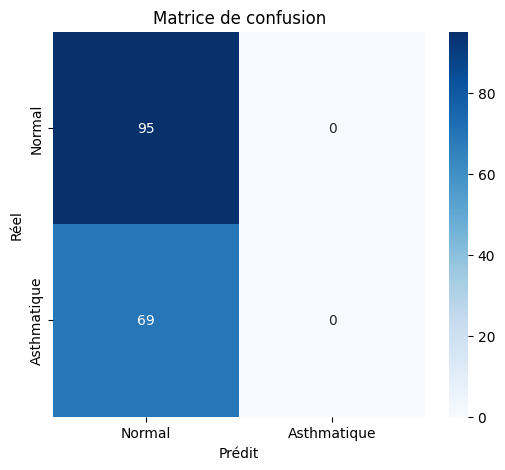

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluation globale
test_loss, test_acc = DL_Model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Prédictions
y_pred_probs = DL_Model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rapport de classification
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred, target_names=classes))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


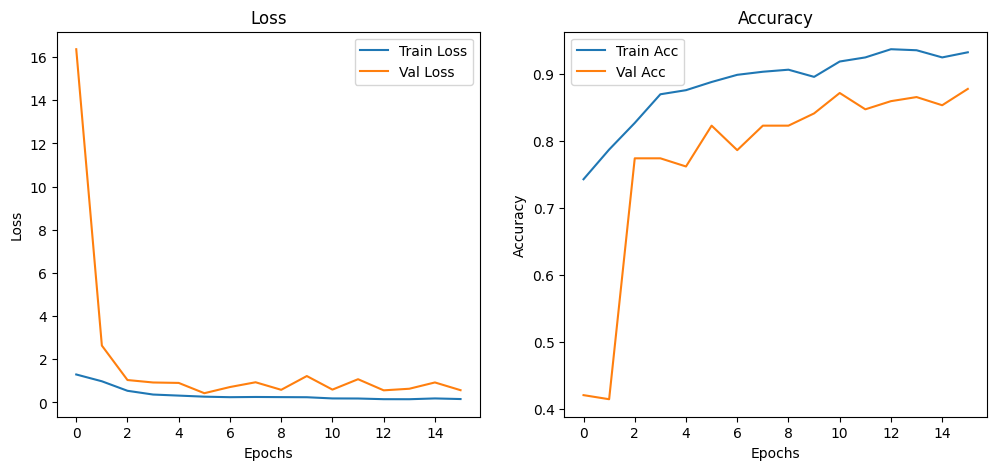

In [ ]:
# Courbes d'entraînement

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Courbe de Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Courbe d'Accuracy")

plt.show()

In [13]:
DL_Model.save('dl_model_asthma.h5')

c:\Users\SANTI\Downloads\Virtual_Environments\python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
